# Best locations to set up tourist E-Scooter stations in Paris

In this project, we will identify the best locations to set up a series of 5 tourist E-Scooters stations in the central area of Paris. Best locations are based on the distribution of tourist attractions within a radius of 10km from Paris center. The list of venues is collected from FourSquare API. 

## 1. Import and declaration

Import necessary libraries

In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
import sys

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

# import k-means from clustering stage
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import matplotlib.pyplot as plt

# Geocoder library to convert centroid coordinates to addresses
import geocoder

print('Libraries imported.')

Libraries imported.


Declare credentials to consume FourSquare API

In [80]:
CLIENT_ID = '<my_client_id>' #  Foursquare ID
CLIENT_SECRET = '<my_secret>' #  Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Credentails:
CLIENT_ID: <my_client_id>
CLIENT_SECRET:<my_secret>


Define the function to parse venue category from JSON response of FourSquare API

In [3]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

## 2. Data collection

### 2.1. Expore Paris and discover venues of interest

First step is to define the central point of Paris. This can be done by using Foursquare agent to translate the representative address “Paris” to longitude and latitude.

In [4]:
address = 'Paris'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

48.8566101 2.3514992


Now we define the radius for the venue scan: 10km from city center

In [5]:
radius = 10000 # 10km from city center
VERSION = 20190101
LIMIT=50
offset=0

From this central point, we use the FourSquare venue recommendation API to explore venues 

In [6]:
# Create a list storing result pages, each page containing 100 venues
explore_data_pages = []
no_of_venues = 0
max_pages = 100

print('Explore venues within {} km from {} city center'.format(radius/1000,address))
for i in range(0,max_pages):
    offset = i * 50
    print('Loading page {}/{}'.format(i+1, max_pages))
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}&offset={}&query=tourist'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT, offset)
    # Explain why using query=tourist instead of section=sights here: https://stackoverflow.com/questions/38231370/foursquare-venues-explore-api-sights
    
    results = requests.get(url).json()
    items = results['response']['groups'][0]['items']
    no_of_venues += len(items)
    
    # Check if all venues within the radius have been returned
    if len(items) == 0:
        print('No more venues')
        break
        
    print('{} venues discovered'.format(no_of_venues))
    
    dataframe = json_normalize(items) # flatten JSON
    # filter columns
    filtered_columns = ['venue.name', 'venue.categories'] + [col for col in dataframe.columns if col.startswith('venue.location.')] + ['venue.id']
    dataframe_filtered = dataframe.loc[:, filtered_columns]
    # filter the category for each row
    dataframe_filtered['venue.categories'] = dataframe_filtered.apply(get_category_type, axis=1)
    # clean columns
    dataframe_filtered.columns = [col.split('.')[-1] for col in dataframe_filtered.columns]
    explore_data_pages.append(dataframe_filtered)
    
        

Explore venues within 10.0 km from Paris city center
Loading page 1/100
50 venues discovered
Loading page 2/100
100 venues discovered
Loading page 3/100
150 venues discovered
Loading page 4/100
200 venues discovered
Loading page 5/100
250 venues discovered
Loading page 6/100
No more venues


Store the raw dataset to an Excel file so as to avoid querying the API again next time

In [7]:
explore_df = pd.concat(explore_data_pages, ignore_index=True, axis=0)
explore_df.to_excel('explore_df.xlsx')

Now let's explore some first rows to have an idea of our dataset

In [8]:
explore_df[['id','name','categories','address','city','country','distance']].head(10)

,id,name,categories,address,city,country,distance
0,4bf41231e5eba59334341f90,Place de l'Hôtel de Ville – Esplanade de la Li...,Plaza,Place de l'Hôtel de Ville,Paris,France,60
1,4adcda09f964a520e83321e3,Cathédrale Notre-Dame de Paris,Church,6 place du parvis Notre-Dame,Paris,France,413
2,4b5c7d1ff964a5205f3229e3,Tour Saint-Jacques,Historic Site,88 rue de Rivoli,Paris,France,248
3,4adcda0af964a520623421e3,Centre Pompidou – Musée National d'Art Moderne,Art Museum,Place Georges Pompidou,Paris,France,458
4,4adcda0af964a520353421e3,Sainte-Chapelle,Church,8 boulevard du Palais,Paris,France,496
5,4dbd336b6a23e294ba405cfa,Square de la Tour Saint-Jacques,Park,88 rue de Rivoli,Paris,France,245
6,4cca7e73c4d06dcbb72d6303,Fontaine Stravinsky,Fountain,Place Stravinsky,Paris,France,330
7,4b8ebd9df964a5203c3433e3,Théâtre du Châtelet,Theater,1 place du Châtelet,Paris,France,404
8,4bae535af964a520f5a23be3,Maison Européenne de la Photographie,Art Museum,5 rue de Fourcy,Paris,France,569
9,4adcda15f964a520a13721e3,Théâtre de la Ville,Theater,2 place du Châtelet,Paris,France,271


With query=tourist in the API request, collected venues are tourist attractions of the following categories:

In [9]:
explore_df['categories'].unique()

array(['Plaza', 'Church', 'Historic Site', 'Art Museum', 'Park',
       'Fountain', 'Theater', 'Memorial Site', 'Garden', 'Museum',
       'Pedestrian Plaza', 'Bridge', 'Art Gallery', 'Concert Hall',
       'Monument / Landmark', 'History Museum', 'Opera House',
       'Botanical Garden', 'Sculpture Garden', 'Science Museum', 'Circus',
       'College Library', 'Canal', 'Trail', 'Event Space', 'Zoo',
       'General Entertainment', 'Arcade', 'Comedy Club', 'Library',
       'Cemetery', 'Street Art', 'Pool', 'Vineyard',
       'Performing Arts Venue', 'Theme Park Ride / Attraction', 'Island',
       'Outdoor Sculpture', 'Castle', 'Forest', 'Radio Station',
       'Rugby Stadium', 'Soccer Stadium', 'TV Station', 'Tennis Court',
       'Shopping Plaza', 'Racecourse', 'Stadium'], dtype=object)

### 2.2. Get venue rating

We want to consider only interesting venues - i.e venues with high number of likes and average user rating. Therefore, next step is to get number of likes and user rating for each of the 250 venues in the list. 

First, we will pick a venue from the list to see how the FourSquare venue details API works.

In [10]:
venue_id = '4adcda09f964a520e83321e3'#Cathédrale Notre-Dame de Paris
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id,CLIENT_ID, CLIENT_SECRET, VERSION)
print(url)
results = requests.get(url).json()

https://api.foursquare.com/v2/venues/4adcda09f964a520e83321e3?client_id=K4PXPBNFVU4LJIUI1HHDT2YD5GUNNSUS43VFV1HJVPJDGF2C&client_secret=BACDGCSYMRDCBJDRS0NB1K2RNUIMVSSKKPSZRAF1H1RHJ54J&v=20190101


Raw JSON response is as follows

In [81]:
results

{'meta': {'code': 200, 'requestId': '5cd5c61fdd579724110ce6d1'},
 'response': {'venue': {'id': '4adcda09f964a520e83321e3',
   'name': 'Cathédrale Notre-Dame de Paris',
   'contact': {'phone': '+33142345610',
    'formattedPhone': '+33 1 42 34 56 10',
    'twitter': 'notredame2paris',
    'facebook': '100572883398118',
    'facebookUsername': 'cathedrale.notredamedeparis',
    'facebookName': 'Cathédrale Notre-Dame de Paris'},
   'location': {'address': '6 place du parvis Notre-Dame',
    'crossStreet': 'Place Jean-Paul II',
    'lat': 48.85312443201169,
    'lng': 2.3495614528656006,
    'labeledLatLngs': [{'label': 'display',
      'lat': 48.85312443201169,
      'lng': 2.3495614528656006}],
    'postalCode': '75004',
    'cc': 'FR',
    'city': 'Paris',
    'state': 'Île-de-France',
    'country': 'France',
    'formattedAddress': ['6 place du parvis Notre-Dame (Place Jean-Paul II)',
     '75004 Paris',
     'France']},
   'canonicalUrl': 'https://foursquare.com/v/cath%C3%A9drale-not

Like count and average user rating can then be parsed from this JSON response

In [12]:
results['response']['venue']['likes']['count']

8518

In [13]:
results['response']['venue']['rating']

9.4

Looks good. Now let's apply this API request for all 250 venues. First we need to define a function to get venue likes and rating from FourSquare API.

In [14]:
def get_venue_likes_and_rating(venue_id):
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id,CLIENT_ID, CLIENT_SECRET, VERSION)
    results = requests.get(url).json()
    try:
        likes = results['response']['venue']['likes']['count']
    except:
        likes = np.nan
        print('Venue {} has no like info'.format(venue_id))
    
    try:    
        rating = results['response']['venue']['rating']
    except:
        rating = np.nan
        print('Venue {} has no rating info'.format(venue_id))
        
    return (likes,rating)

Initiate values for 2 columns "no_of_likes" and "rating", default null

In [15]:
explore_df['no_of_likes'],explore_df['rating'] = (np.nan,np.nan)

Loop through the list of 250 venues, get number of likes and rating for each venue. Each venue details API request requires a premium call. A FourSquare personal account allows 500 premium calls per day, which is sufficient to cover these 250 venues in a single batch. 

In [16]:
venue_count = explore_df.shape[0]

In [17]:
from ipywidgets import IntProgress #library to display progress bar
from IPython.display import display

print('Loading venue')

f = IntProgress(min=0, max=venue_count) # instantiate the bar
display(f) # display the bar

row_no = 0
while row_no < venue_count:
    venue_id = explore_df.at[row_no,'id']
    likes_rating = get_venue_likes_and_rating(venue_id)
    explore_df.at[row_no,'no_of_likes'] = likes_rating[0]
    explore_df.at[row_no,'rating'] = likes_rating[1]
    f.value += 1 # signal to increment the progress bar
    f.description = '{}/{}'.format(row_no+1, venue_count)
    row_no += 1

Loading venue


IntProgress(value=0, max=250)

250 venue details API requests have been sent successfully to FourSquare. A quick summary below shows that all venues have user likes and rating (no NULL values in these fields).

In [18]:
explore_df['no_of_likes'].isnull().any()

False

In [19]:
explore_df['rating'].isnull().any()

False

Store the raw dataset to an Excel file so as to avoid querying the API again next time

In [20]:
explore_df.to_excel('explore_df_withrating.xlsx')

Let's explore the dataset again. 2 new columns "no_of_likes" and "rating" have been added

In [83]:
explore_df[['id','name','categories','address','city','country','distance','no_of_likes','rating']].head(10)

,id,name,categories,address,city,country,distance,no_of_likes,rating
0,4bf41231e5eba59334341f90,Place de l'Hôtel de Ville – Esplanade de la Li...,Plaza,Place de l'Hôtel de Ville,Paris,France,60,579.0,9.1
1,4adcda09f964a520e83321e3,Cathédrale Notre-Dame de Paris,Church,6 place du parvis Notre-Dame,Paris,France,413,8518.0,9.4
2,4b5c7d1ff964a5205f3229e3,Tour Saint-Jacques,Historic Site,88 rue de Rivoli,Paris,France,248,272.0,8.7
3,4adcda0af964a520623421e3,Centre Pompidou – Musée National d'Art Moderne,Art Museum,Place Georges Pompidou,Paris,France,458,5325.0,9.2
4,4adcda0af964a520353421e3,Sainte-Chapelle,Church,8 boulevard du Palais,Paris,France,496,585.0,9.1
5,4dbd336b6a23e294ba405cfa,Square de la Tour Saint-Jacques,Park,88 rue de Rivoli,Paris,France,245,41.0,8.4
6,4cca7e73c4d06dcbb72d6303,Fontaine Stravinsky,Fountain,Place Stravinsky,Paris,France,330,103.0,8.5
7,4b8ebd9df964a5203c3433e3,Théâtre du Châtelet,Theater,1 place du Châtelet,Paris,France,404,228.0,8.6
8,4bae535af964a520f5a23be3,Maison Européenne de la Photographie,Art Museum,5 rue de Fourcy,Paris,France,569,358.0,9.0
9,4adcda15f964a520a13721e3,Théâtre de la Ville,Theater,2 place du Châtelet,Paris,France,271,76.0,8.4


## 3. Data exploration

### 3.1. Define thresholds to filter the list of venues

We want our customers to have the best tourist experience, so we are only interested in venues that are widely liked by FourSquare users. This means we will consider venues having relatively high number of likes and user rating in our dataset. We'll start by examining the value distribution of these two fields. 

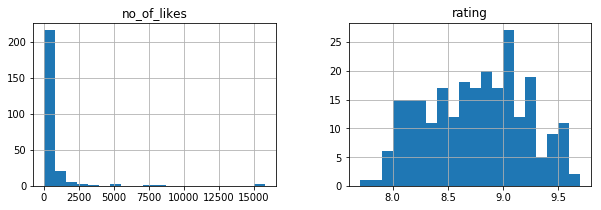

In [32]:
hist = explore_df[['no_of_likes','rating']].hist(bins=20, figsize = (10,3))

For user rating, the histogram is pretty close to a standard “bell shape” with majority of the values larger than 8.0. Therefore, minimum rating = 8.0 should be a reasonable threshold.

For number of likes, the plot is not that clear. It gives a rough idea that some particular venues (most likely famous ones like Notre-Dame) receive extraordinary high number of likes. 

Let's zoom the no_of_likes histogram to see it clearer where most venues are distributed. We can see that majority of other less well-known venues receive fewer than approximately 300 likes

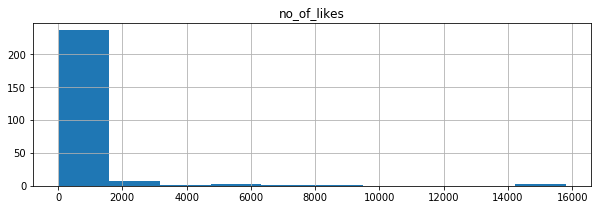

In [33]:
likes_df = explore_df[['no_of_likes']]
hist = likes_df.hist(bins=10, figsize = (10,3))

Zooming into this range, we have the following histogram:

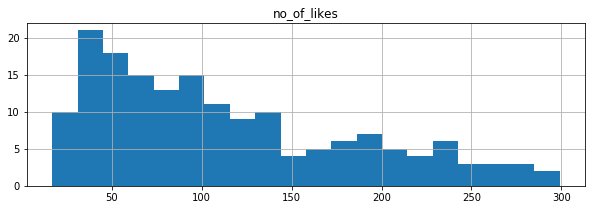

In [34]:
likes_df = likes_df[likes_df['no_of_likes'] < 300]
hist = likes_df.hist(bins=20, figsize = (10,3))

For this distribution, 50 should be an acceptable choice for the threshold of no_of_likes. 

In [85]:
# Define thresholds
MIN_LIKES = 50
MIN_RATING = 8.0

Applying these two thresholds to the original dataset (number of likes >= 50 and user rating >= 8.0), we have a subset of 209 venues.

In [63]:
explore_df_filtered = explore_df[ (explore_df['no_of_likes'] >= MIN_LIKES) & (explore_df['rating'] >= MIN_RATING)]

In [64]:
explore_df_filtered.shape

(209, 18)

Let’s plot all the 209 venues on a Paris map to have an initial idea of their distribution within the city

In [65]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around the Conrad Hotel

# add the explored venues as blue circle markers
for lat, lng, label in zip(explore_df_filtered.lat, explore_df_filtered.lng, explore_df_filtered.name):
    folium.features.CircleMarker(
        [lat, lng],
        radius=2,
        color='blue',
        #popup=label,
        popup='',
        fill = True,
        fill_color='blue',
        fill_opacity=1
    ).add_to(venues_map)
    
# add a red circle marker to represent the city center
folium.features.CircleMarker(
    [latitude, longitude],
    radius=8,
    color='red',
    popup='City Center',
    fill = True,
    fill_color = 'red',
    fill_opacity = 1
).add_to(venues_map)

# display map
venues_map

### 3.2. Detect and remove outliers

At a quick glance of the map, we can see that there are some venues on the north, west and south-east areas (marked with red circles) that are quite far away from the majority of other venues. Setting up E-Scooter stations to cover these venues seems not to be economically efficient, as they tend to “drag” the latest E-Scooter station towards them when running the clustering step. On an algorithm perspective, they can be considered as outliers that significantly affect centroids locations.

Draw box plot for venue lattitude with default whisker length = 1.5 IQR

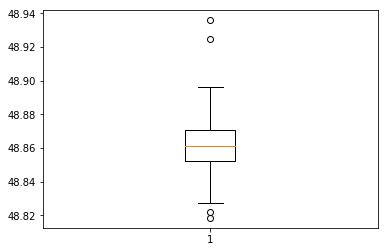

In [67]:
venue_latitudes = explore_df[['lat']].values
box_lat=plt.boxplot(venue_latitudes)

Get values of lower and higher whiskers for later filterting

In [68]:
lat_lower_whisker=box_lat['whiskers'][0].get_ydata()[1]
lat_upper_whisker=box_lat['whiskers'][1].get_ydata()[1]
print(lat_lower_whisker)
print(lat_upper_whisker)

48.827416879903076
48.895971265855046


Same with venue longitude

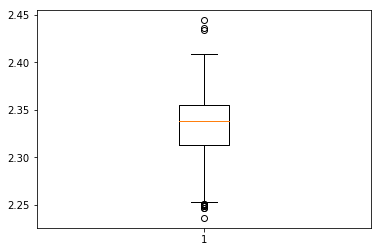

In [69]:
venue_longitudes = explore_df[['lng']].values
box_lng=plt.boxplot(venue_longitudes)

In [70]:
lng_lower_whisker=box_lng['whiskers'][0].get_ydata()[1]
lng_upper_whisker=box_lng['whiskers'][1].get_ydata()[1]
print(lng_lower_whisker)
print(lng_upper_whisker)

2.2525489157221834
2.4090357891450678


Remove venues falling out of upper and lower bounds of latitudes and longitudes

In [72]:
explore_df_no_outliers = explore_df_filtered[ \
    (explore_df_filtered['lat'] >= lat_lower_whisker) & \
    (explore_df_filtered['lat'] <= lat_upper_whisker) & \
    (explore_df_filtered['lng'] >= lng_lower_whisker) & \
    (explore_df_filtered['lng'] <= lng_upper_whisker)]

Now let's have a look at the dataset after removing outliers

In [73]:
explore_df_no_outliers.shape

(195, 18)

We can see that number of outliers decreases from 209 to 195 after removal of outliers. 12 outliers have been removed.
When plotting the venues, the resulting map no longer shows isolated venues.

For visualization purposes, we will show the removed venues (outliers) as light red smaller points in the following map

In [48]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) 

explore_df_outliers = explore_df_filtered[ \
    (explore_df_filtered['lat'] < lat_lower_whisker) | \
    (explore_df_filtered['lat'] > lat_upper_whisker) | \
    (explore_df_filtered['lng'] < lng_lower_whisker) | \
    (explore_df_filtered['lng'] > lng_upper_whisker)]

# add the outliers as red circle markers
for lat, lng, label in zip(explore_df_outliers.lat, explore_df_outliers.lng, explore_df_outliers.name):
    folium.features.CircleMarker(
        [lat, lng],
        radius=3,
        color='red',
        #popup=label,
        popup='',
        fill = True,
        fill_color='red',
        fill_opacity=1
    ).add_to(venues_map)
    
# add the accepted venues as blue circle markers
for lat, lng, label in zip(explore_df_no_outliers.lat, explore_df_no_outliers.lng, explore_df_no_outliers.name):
    folium.features.CircleMarker(
        [lat, lng],
        radius=2,
        color='blue',
        #popup=label,
        popup='',
        fill = True,
        fill_color='blue',
        fill_opacity=1
    ).add_to(venues_map)
    
# add a red circle marker to represent the city center
folium.features.CircleMarker(
    [latitude, longitude],
    radius=8,
    color='red',
    popup='City Center',
    fill = True,
    fill_color = 'red',
    fill_opacity = 1
).add_to(venues_map)

# display map
venues_map

## 4. Clustering venues

We will use K-Means clustering algorithm to group the list of venues into 5 clusters. Centroids these clusters are considered as the best 5 best locations to set up E-Scooter stations we are looking for.

Features being used in the algorithm are only coordinates (latitudes, longitudes) of venues.

In [49]:
explore_df_clustering = explore_df_no_outliers[['lat','lng']]

In [50]:
explore_df_clustering.head()

,lat,lng
0,48.857138,2.351693
1,48.853124,2.349561
2,48.858031,2.348875
3,48.860730,2.351660
4,48.855395,2.344975


In [51]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(explore_df_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1])

In [52]:
# add clustering labels
explore_df_no_outliers.insert(0, 'clusterLabel', kmeans.labels_)

After applying K-Means clustering, each venue is identified with a cluster label from 0-4. The resulting dataset is as follows:

In [61]:
explore_df_no_outliers[['id','name','clusterLabel','categories','address','city','country','no_of_likes','rating']].head(10)

,id,name,clusterLabel,categories,address,city,country,no_of_likes,rating
0,4bf41231e5eba59334341f90,Place de l'Hôtel de Ville – Esplanade de la Li...,1,Plaza,Place de l'Hôtel de Ville,Paris,France,579.0,9.1
1,4adcda09f964a520e83321e3,Cathédrale Notre-Dame de Paris,1,Church,6 place du parvis Notre-Dame,Paris,France,8518.0,9.4
2,4b5c7d1ff964a5205f3229e3,Tour Saint-Jacques,1,Historic Site,88 rue de Rivoli,Paris,France,272.0,8.7
3,4adcda0af964a520623421e3,Centre Pompidou – Musée National d'Art Moderne,1,Art Museum,Place Georges Pompidou,Paris,France,5325.0,9.2
4,4adcda0af964a520353421e3,Sainte-Chapelle,1,Church,8 boulevard du Palais,Paris,France,585.0,9.1
6,4cca7e73c4d06dcbb72d6303,Fontaine Stravinsky,1,Fountain,Place Stravinsky,Paris,France,103.0,8.5
7,4b8ebd9df964a5203c3433e3,Théâtre du Châtelet,1,Theater,1 place du Châtelet,Paris,France,228.0,8.6
8,4bae535af964a520f5a23be3,Maison Européenne de la Photographie,0,Art Museum,5 rue de Fourcy,Paris,France,358.0,9.0
9,4adcda15f964a520a13721e3,Théâtre de la Ville,1,Theater,2 place du Châtelet,Paris,France,76.0,8.4
10,4c00046cc30a2d7fbeda111d,Parvis Notre-Dame — Place Jean-Paul II,1,Plaza,Parvis Notre-Dame,Paris,France,223.0,8.5


Let's visualize the 5 clusters resulting from the K-Means clustering algorithm into a map. Each cluster is plotted with a dedicated color. Centroids the five clusters are also visualized as place markers.

In [53]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
#x = np.arange(kclusters)
#ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]
rainbow = ['#4152d0','#6601c6','#873600','#ff7f11','#d00000']

# add markers to the map
for lat, lon, cluster in zip(explore_df_no_outliers['lat'], explore_df_no_outliers['lng'], explore_df_no_outliers['clusterLabel']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(map_clusters)

for i in range(0,kclusters):
    label = ''
    centroid = kmeans.cluster_centers_[i]
    folium.Marker(
        centroid,
        popup=label).add_to(map_clusters)
       
map_clusters

Coordinates of the 5 identified centroids 

In [74]:
centroids = kmeans.cluster_centers_
centroids

array([[48.85022711,  2.36611467],
       [48.86425525,  2.33842997],
       [48.85450928,  2.26530539],
       [48.88482816,  2.3852195 ],
       [48.86413735,  2.30325019]])

For a meaningful conclusion, we will apply reverse geocoding to translate these coordinates to physical address. 

In [77]:
print('Recommended locations to set up E-Scooter stations:')

i=0
for c in centroids:
    i+=1
    g = geocoder.geocodefarm(list(c), method='reverse')
    address = g.json['address']
    print('{}. {}'.format(i,address))
    

Recommended locations to set up E-Scooter stations:
1. 14 Rue Crillon, 75004 Paris, France
2. 13 Rue de Valois, 75001 Paris, France
3. 18 Rue du Docteur Blanche, 75016 Paris, France
4. 10 Rue André Danjon, 75019 Paris, France
5. 51 Cours Albert 1er, 75008 Paris, France


As suggested by the outcome of the clustering algorithm, E-Scooter stations should be set up at the above 5 addresses.